In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import make_scorer, classification_report, confusion_matrix, log_loss, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
from tqdm import tqdm

In [10]:
og_df = pd.read_csv('pd_speech_features.csv')
og_df

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,...,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
1,0,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,...,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780,1
2,0,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,...,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1
3,1,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,...,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603,1
4,1,0,0.32790,0.79782,0.53028,236,235,0.008162,0.002669,0.00535,...,6.1727,5.8416,6.0805,5.7621,7.7817,11.6891,8.2103,5.0559,6.1164,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,250,0,0.80903,0.56355,0.28385,417,416,0.004627,0.000052,0.00064,...,3.0706,3.0190,3.1212,2.4921,3.5844,3.5400,3.3805,3.2003,6.8671,0
752,250,0,0.16084,0.56499,0.59194,415,413,0.004550,0.000220,0.00143,...,1.9704,1.7451,1.8277,2.4976,5.2981,4.2616,6.3042,10.9058,28.4170,0
753,251,0,0.88389,0.72335,0.46815,381,380,0.005069,0.000103,0.00076,...,51.5607,44.4641,26.1586,6.3076,2.8601,2.5361,3.5377,3.3545,5.0424,0
754,251,0,0.83782,0.74890,0.49823,340,339,0.005679,0.000055,0.00092,...,19.1607,12.8312,8.9434,2.2044,1.9496,1.9664,2.6801,2.8332,3.7131,0


In [11]:
X = og_df.drop(columns=['class'])  # Features
y = og_df['class']  # Target

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA for dimensionality reduction
pca = PCA(n_components=25)  # You can adjust the number of components as needed
X_pca = pca.fit_transform(X_scaled)

# Create a new dataframe with reduced dimensions
reduced_df = pd.DataFrame(X_pca, columns=[f'PC{i}' for i in range(1, pca.n_components_ + 1)])
reduced_df['class'] = y  # Add the target back to the dataframe if needed
reduced_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,class
0,-10.047372,1.471076,-6.846403,-0.782090,-3.440105,-0.053208,1.961631,0.938642,0.439705,-0.443896,...,-1.132688,1.636691,1.324074,0.516937,-1.226503,-3.311395,-2.704597,0.288131,1.403527,1
1,-10.637725,1.583749,-6.830977,1.415978,-3.200764,1.724359,2.109031,2.244236,0.611466,1.269720,...,0.095133,-0.371872,-0.457215,1.625661,-3.218728,-1.361446,-2.315008,-0.850492,1.894323,1
2,-13.516185,-1.253543,-6.818697,1.412663,-2.284052,2.567108,0.715761,1.084709,0.094852,-1.508254,...,-1.267225,2.114735,0.652956,1.391598,-0.495734,-1.713206,-2.282328,-0.527249,1.526629,1
3,-9.155084,8.833599,15.290902,-4.036450,-5.139308,-9.570312,-2.916907,-5.211641,-4.798260,5.187691,...,0.586903,0.421357,-0.887026,-0.616952,0.089205,-1.108139,1.275819,1.673985,2.556727,1
4,-6.764470,4.611466,15.637120,-5.847869,-5.794314,-11.050850,-1.310725,-5.386988,-7.927586,7.284822,...,0.789326,-0.701732,0.109749,-0.179059,1.360528,-1.703689,1.778497,1.049565,1.564762,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,22.322682,6.481911,1.458753,11.207482,-4.812522,7.460025,-2.133412,-7.099872,-1.030111,3.470669,...,-0.814233,-3.347758,-0.936005,4.885378,-0.126898,-0.337041,-1.875879,0.511303,0.631116,0
752,13.442877,1.449412,9.352294,8.836102,-3.941493,4.466552,-7.503461,-5.409326,-0.953721,2.405372,...,-0.397352,1.077677,0.573969,0.613759,4.592636,-2.085744,-3.290432,3.391276,-1.546382,0
753,8.270264,2.391285,-0.908670,-2.158860,-0.968910,0.928124,1.859260,-1.332699,0.591687,-0.262489,...,2.424409,-0.007937,-1.240084,1.931325,1.503644,-1.959107,0.506190,-1.636724,-3.274337,0
754,4.011760,5.412257,-0.847132,-3.953489,0.324531,0.784753,0.300637,-0.805656,-0.840037,-0.737268,...,2.819730,-0.288228,-1.599299,-0.161689,2.166690,-1.429435,0.597726,-1.142098,-1.250112,0


## Exploritory Data Analysis

## Pre Processing

### Feature Selection

In [5]:
X = reduced_df.drop(columns=['class'])
y = reduced_df['class']

correlation_coefficients = {}
for column in X.columns:
    correlation, _ = spearmanr(X[column], y)
    correlation_coefficients[column] = abs(correlation)

# Sort the features based on their correlation coefficients
sorted_features = sorted(correlation_coefficients.items(), key=lambda x: x[1], reverse=True)

# Select the top n features
n_features = 19  # You can change this value as needed
selected_features = [feature[0] for feature in sorted_features[:n_features]]

# Filter the dataset to include only the selected features
X_selected = X[selected_features]

In [6]:
# sorted_features[:27] # 0.35 correlation threshold cutoff
# sorted_features[:14] # 0.37 correlation threshold cutoff
sorted_features[:19] # 0.38 correlation threshold cutoff
# sorted_features[:76] # 0.30 correlation threshold cutoff

[('PC1', 0.41851422716497966),
 ('PC6', 0.17064452534957497),
 ('PC5', 0.1393283656179394),
 ('PC22', 0.13207371056227815),
 ('PC17', 0.12830017597478446),
 ('PC7', 0.12703304812437147),
 ('PC3', 0.1229949483812971),
 ('PC19', 0.10809575277753983),
 ('PC13', 0.10652228632592808),
 ('PC10', 0.10638304150720138),
 ('PC8', 0.08023286455032648),
 ('PC25', 0.07904928359114949),
 ('PC11', 0.07198957128170565),
 ('PC24', 0.07173893060799756),
 ('PC21', 0.06349563733937674),
 ('PC20', 0.06249307464454447),
 ('PC14', 0.056310604693078845),
 ('PC16', 0.05303835145300131),
 ('PC2', 0.05204971324004172)]

In [12]:
X_selected

,PC1,PC6,PC5,PC22,PC17,PC7,PC3,PC19,PC13,PC10,PC8,PC25,PC11,PC24,PC21,PC20,PC14,PC16,PC2
0,-10.047372,-0.053206,-3.440104,-3.367941,-1.133042,1.961617,-6.846403,1.322826,0.746452,-0.443286,0.938673,1.361601,-0.373651,-0.111536,-1.167787,0.545148,-0.838790,-0.541102,1.471076
1,-10.637725,1.724360,-3.200762,-1.362544,0.106029,2.109028,-6.830977,-0.452985,1.361211,1.270257,2.244246,1.720400,1.400299,1.006843,-3.174068,1.646932,-0.437562,-1.922362,1.583749
2,-13.516185,2.567104,-2.284051,-1.740832,-1.264827,0.715758,-6.818697,0.659290,0.676795,-1.507833,1.084758,1.231641,-1.380162,0.640430,-0.418056,1.414713,-0.592220,-0.257104,-1.253543
3,-9.155084,-9.570289,-5.139305,-1.137660,0.611590,-2.916837,15.290902,-0.919833,5.713663,5.187504,-5.211857,2.434983,5.566913,-1.119865,0.217548,-0.544840,2.567991,-2.125874,8.833599
4,-6.764470,-11.050842,-5.794314,-1.693675,0.804800,-1.310696,15.637120,0.096358,4.643315,7.284638,-5.387085,1.506570,1.806415,-0.901333,1.414844,-0.167869,3.804466,-0.581853,4.611466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,22.322682,7.460050,-4.812518,-0.366516,-0.773977,-2.133288,1.458753,-0.951433,3.004202,3.469619,-7.100166,0.132715,4.259462,0.373273,0.044454,4.984476,1.385181,-2.499878,6.481911
752,13.442877,4.466562,-3.941492,-2.126297,-0.383791,-7.503407,9.352294,0.561434,3.863284,2.404922,-5.409466,-1.713901,4.026589,-3.036810,4.669170,0.650091,-0.571737,-3.767838,1.449412
753,8.270264,0.928113,-0.968911,-1.921815,2.398432,1.859224,-0.908670,-1.222894,-0.380931,-0.262427,-1.332586,-2.927226,1.571069,1.286147,1.442812,1.882144,0.285927,1.712615,2.391285
754,4.011760,0.784741,0.324533,-1.427223,2.819512,0.300618,-0.847132,-1.583131,0.924452,-0.736968,-0.805526,-1.501878,2.035330,1.001195,2.226098,-0.171786,2.475903,-0.945208,5.412257


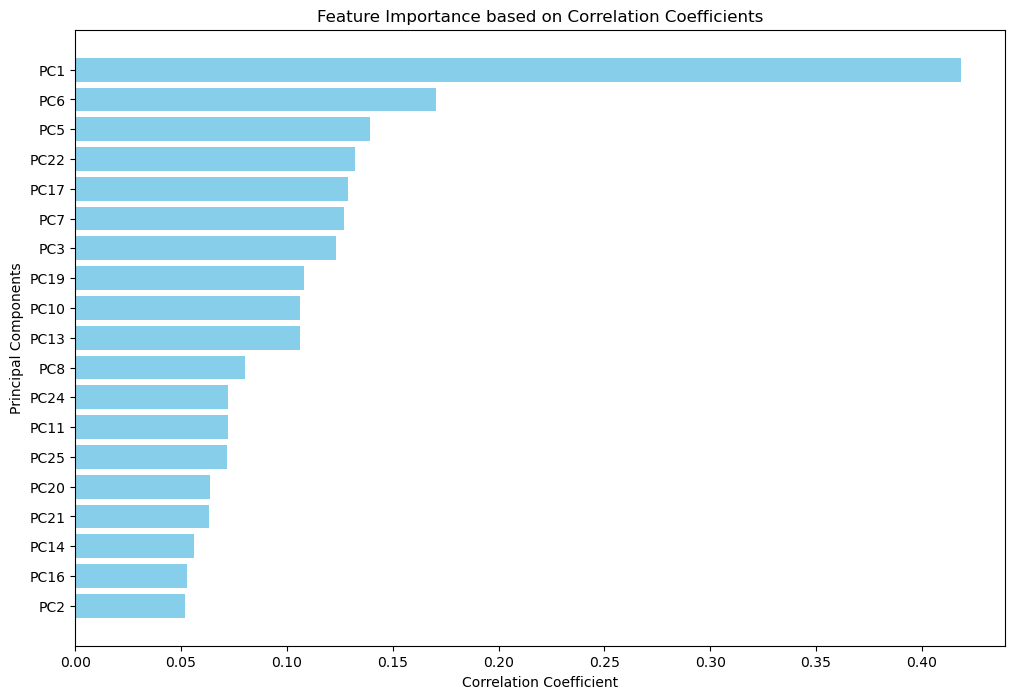

In [9]:
features = [feature[0] for feature in sorted_features[:n_features]]
coefficients = [feature[1] for feature in sorted_features[:n_features]]

# Plotting
plt.figure(figsize=(12, 8))
plt.barh(features, coefficients, color='skyblue')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Principal Components')
plt.title('Feature Importance based on Correlation Coefficients')
plt.gca().invert_yaxis()  # Invert y-axis to display highest correlation at the top
plt.show()

In [8]:
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X_selected)

# Variance Scaling
# Note: VarianceThreshold removes features whose variance doesn't meet a certain threshold
# Here we'll use a threshold of 0.01
variance_scaler = MinMaxScaler()
X_variance_scaled = variance_scaler.fit_transform(X_standardized)

# Convert back to DataFrame
X_processed = pd.DataFrame(X_variance_scaled, columns=X_selected.columns)

In [9]:
df = pd.concat([X_processed, y], axis=1)
print(df)

          PC1       PC6       PC5      PC22      PC17       PC7       PC3  \
0    0.333775  0.274706  0.364571  0.105597  0.388800  0.422626  0.020901   
1    0.324812  0.302960  0.368388  0.165789  0.409928  0.425140  0.021070   
2    0.281108  0.316355  0.383012  0.154435  0.386553  0.401376  0.021205   
3    0.347322  0.123436  0.337465  0.172539  0.418548  0.339415  0.263658   
4    0.383618  0.099903  0.327016  0.155850  0.421843  0.366811  0.267454   
..        ...       ...       ...       ...       ...       ...       ...   
751  0.825243  0.394127  0.342678  0.195685  0.394923  0.352780  0.111975   
752  0.690423  0.346547  0.356572  0.142865  0.401576  0.261182  0.198535   
753  0.611888  0.290304  0.403991  0.149003  0.449016  0.420880  0.086014   
754  0.547232  0.288025  0.424624  0.163848  0.456196  0.394295  0.086689   
755  0.546949  0.236092  0.452822  0.185349  0.445196  0.404430  0.073819   

         PC19      PC13      PC10       PC8      PC25      PC11      PC24  

In [28]:
string='PC1'

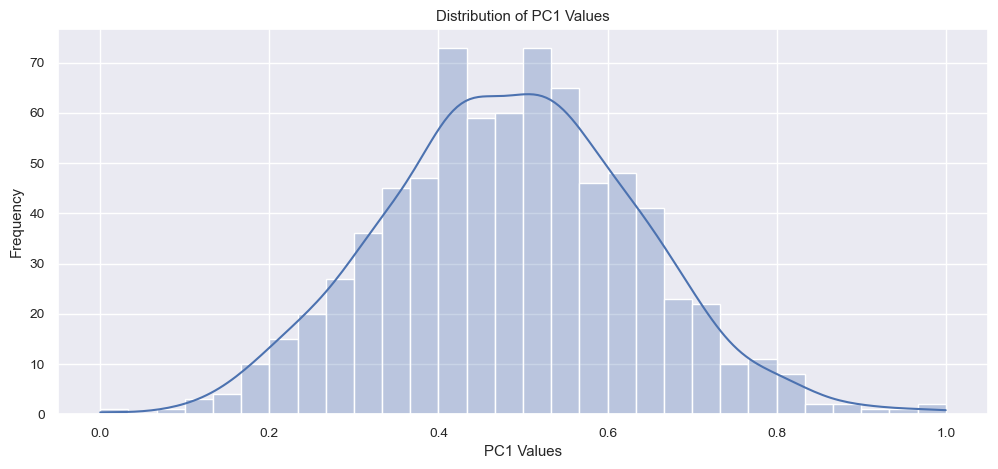

In [44]:
df[string] = df[string].replace([np.inf, -np.inf], np.nan)

# Ignoring FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.figure(figsize=(12, 5))
ax = sns.histplot(df[string], bins=30, color='b', alpha = 0.3, kde=True)
ax.set_title('Distribution of PC1 Values')
ax.set_xlabel('PC1 Values')
ax.set_ylabel('Frequency')
plt.show()

## RF Modeling Running

In [14]:
X = reduced_df.drop(columns=['class'])
y = reduced_df['class']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=28)

# Initialize Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=28)

# Fit Random Forest Classifier
rf_classifier.fit(X_train, y_train)

# Predict probabilities for train and validation set
y_train_pred = rf_classifier.predict_proba(X_train)[:, 1]
y_val_pred = rf_classifier.predict_proba(X_test)[:, 1]

# Compute loss for train and validation set
train_loss = log_loss(y_train, y_train_pred)
val_loss = log_loss(y_test, y_val_pred)

# Predict labels for train and validation set
y_train_pred_labels = rf_classifier.predict(X_train)
y_test_pred_labels = rf_classifier.predict(X_test)

# Compute accuracy for train and validation set
train_accuracy = accuracy_score(y_train, y_train_pred_labels)
test_accuracy = accuracy_score(y_test, y_test_pred_labels)

# Compute ROC curve for train and validation set
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_val_pred)

# Compute AUC for train and validation set
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Print evaluation metrics
print("Accuracy:", test_accuracy)
print("Precision:", precision_score(y_test, y_test_pred_labels, average='weighted', zero_division=1))
print("Recall:", recall_score(y_test, y_test_pred_labels, average='weighted'))
print("F1-score:", f1_score(y_test, y_test_pred_labels, average='weighted'))
print("Classification Report:")
print(classification_report(y_test, y_test_pred_labels))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_labels))

Accuracy: 0.8881578947368421
Precision: 0.8917606516290726
Recall: 0.8881578947368421
F1-score: 0.8800154151068046
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.62      0.74        39
           1       0.88      0.98      0.93       113

    accuracy                           0.89       152
   macro avg       0.90      0.80      0.83       152
weighted avg       0.89      0.89      0.88       152

Confusion Matrix:
[[ 24  15]
 [  2 111]]


### Logisitic Regression Modeling Running

In [23]:
X = reduced_df.drop(columns=['class'])
y = reduced_df['class']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=28)

# Initialize Logistic Regression Classifier
logreg_classifier = LogisticRegression(random_state=28)

# Fit Logistic Regression Classifier
logreg_classifier.fit(X_train, y_train)

# Predict probabilities for train and validation set
y_train_pred = logreg_classifier.predict_proba(X_train)[:, 1]
y_val_pred = logreg_classifier.predict_proba(X_test)[:, 1]

# Compute loss for train and validation set
train_loss = log_loss(y_train, y_train_pred)
val_loss = log_loss(y_test, y_val_pred)

# Predict labels for train and validation set
y_train_pred_labels = logreg_classifier.predict(X_train)
y_test_pred_labels = logreg_classifier.predict(X_test)

# Compute accuracy for train and validation set
train_accuracy = accuracy_score(y_train, y_train_pred_labels)
test_accuracy = accuracy_score(y_test, y_test_pred_labels)

# Compute ROC curve for train and validation set
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_val_pred)

# Compute AUC for train and validation set
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Print evaluation metrics
print("Accuracy:", test_accuracy)
print("Precision:", precision_score(y_test, y_test_pred_labels, average='weighted', zero_division=1))
print("Recall:", recall_score(y_test, y_test_pred_labels, average='weighted'))
print("F1-score:", f1_score(y_test, y_test_pred_labels, average='weighted'))
print("Classification Report:")
print(classification_report(y_test, y_test_pred_labels))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_labels))

Accuracy: 0.8618421052631579
Precision: 0.8572799827437445
Recall: 0.8618421052631579
F1-score: 0.855477384488047
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.62      0.70        39
           1       0.88      0.95      0.91       113

    accuracy                           0.86       152
   macro avg       0.84      0.78      0.80       152
weighted avg       0.86      0.86      0.86       152

Confusion Matrix:
[[ 24  15]
 [  6 107]]


### SVM Modeling Running

In [24]:
X = reduced_df.drop(columns=['class'])
y = reduced_df['class']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=28)

# Initialize Support Vector Machine Classifier
svm_classifier = SVC(probability=True, random_state=28)  # You may need to adjust hyperparameters like kernel, C, etc.

# Fit Support Vector Machine Classifier
svm_classifier.fit(X_train, y_train)

# Predict probabilities for train and validation set
y_train_pred = svm_classifier.predict_proba(X_train)[:, 1]
y_val_pred = svm_classifier.predict_proba(X_test)[:, 1]

# Compute loss for train and validation set
train_loss = log_loss(y_train, y_train_pred)
val_loss = log_loss(y_test, y_val_pred)

# Predict labels for train and validation set
y_train_pred_labels = svm_classifier.predict(X_train)
y_test_pred_labels = svm_classifier.predict(X_test)

# Compute accuracy for train and validation set
train_accuracy = accuracy_score(y_train, y_train_pred_labels)
test_accuracy = accuracy_score(y_test, y_test_pred_labels)

# Compute ROC curve for train and validation set
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_val_pred)

# Compute AUC for train and validation set
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Print evaluation metrics
print("Accuracy:", test_accuracy)
print("Precision:", precision_score(y_test, y_test_pred_labels, average='weighted', zero_division=1))
print("Recall:", recall_score(y_test, y_test_pred_labels, average='weighted'))
print("F1-score:", f1_score(y_test, y_test_pred_labels, average='weighted'))
print("Classification Report:")
print(classification_report(y_test, y_test_pred_labels))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_labels))

Accuracy: 0.881578947368421
Precision: 0.885814338997099
Recall: 0.881578947368421
F1-score: 0.872080592105263
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.59      0.72        39
           1       0.87      0.98      0.92       113

    accuracy                           0.88       152
   macro avg       0.90      0.79      0.82       152
weighted avg       0.89      0.88      0.87       152

Confusion Matrix:
[[ 23  16]
 [  2 111]]


## MLP Modeling Running

In [28]:
X = reduced_df.drop(columns=['class'])
y = reduced_df['class']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=28)

# Initialize MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(150,), activation='tanh', alpha=0.001, solver='sgd',
                               learning_rate='adaptive', shuffle=True, max_iter=1, random_state=28)

train_loss = []
val_loss = []
train_accuracy = []
test_accuracy = []
roc_auc_train = []
roc_auc_test = []

for i in tqdm(range(800)):
    mlp_classifier.partial_fit(X_train, y_train, classes=np.unique(y_train))
    y_train_pred = mlp_classifier.predict_proba(X_train)[:, 1]
    train_loss.append(log_loss(y_train, y_train_pred))
    y_val_pred = mlp_classifier.predict_proba(X_test)[:, 1]
    val_loss.append(log_loss(y_test, y_val_pred))

    y_train_pred_labels = mlp_classifier.predict(X_train)
    train_accuracy.append(accuracy_score(y_train, y_train_pred_labels))

    y_test_pred_labels = mlp_classifier.predict(X_test)
    test_accuracy.append(accuracy_score(y_test, y_test_pred_labels))

    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
    roc_auc_train.append(auc(fpr_train, tpr_train))

    fpr_test, tpr_test, _ = roc_curve(y_test, y_val_pred)
    roc_auc_test.append(auc(fpr_test, tpr_test))

100%|██████████| 800/800 [00:09<00:00, 85.50it/s] 


Accuracy: 0.9078947368421053
Precision: 0.9064271641671022
Recall: 0.9078947368421053
F1-score: 0.905248033877798
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.74      0.81        39
           1       0.92      0.96      0.94       113

    accuracy                           0.91       152
   macro avg       0.90      0.85      0.87       152
weighted avg       0.91      0.91      0.91       152

Confusion Matrix:
[[ 29  10]
 [  4 109]]


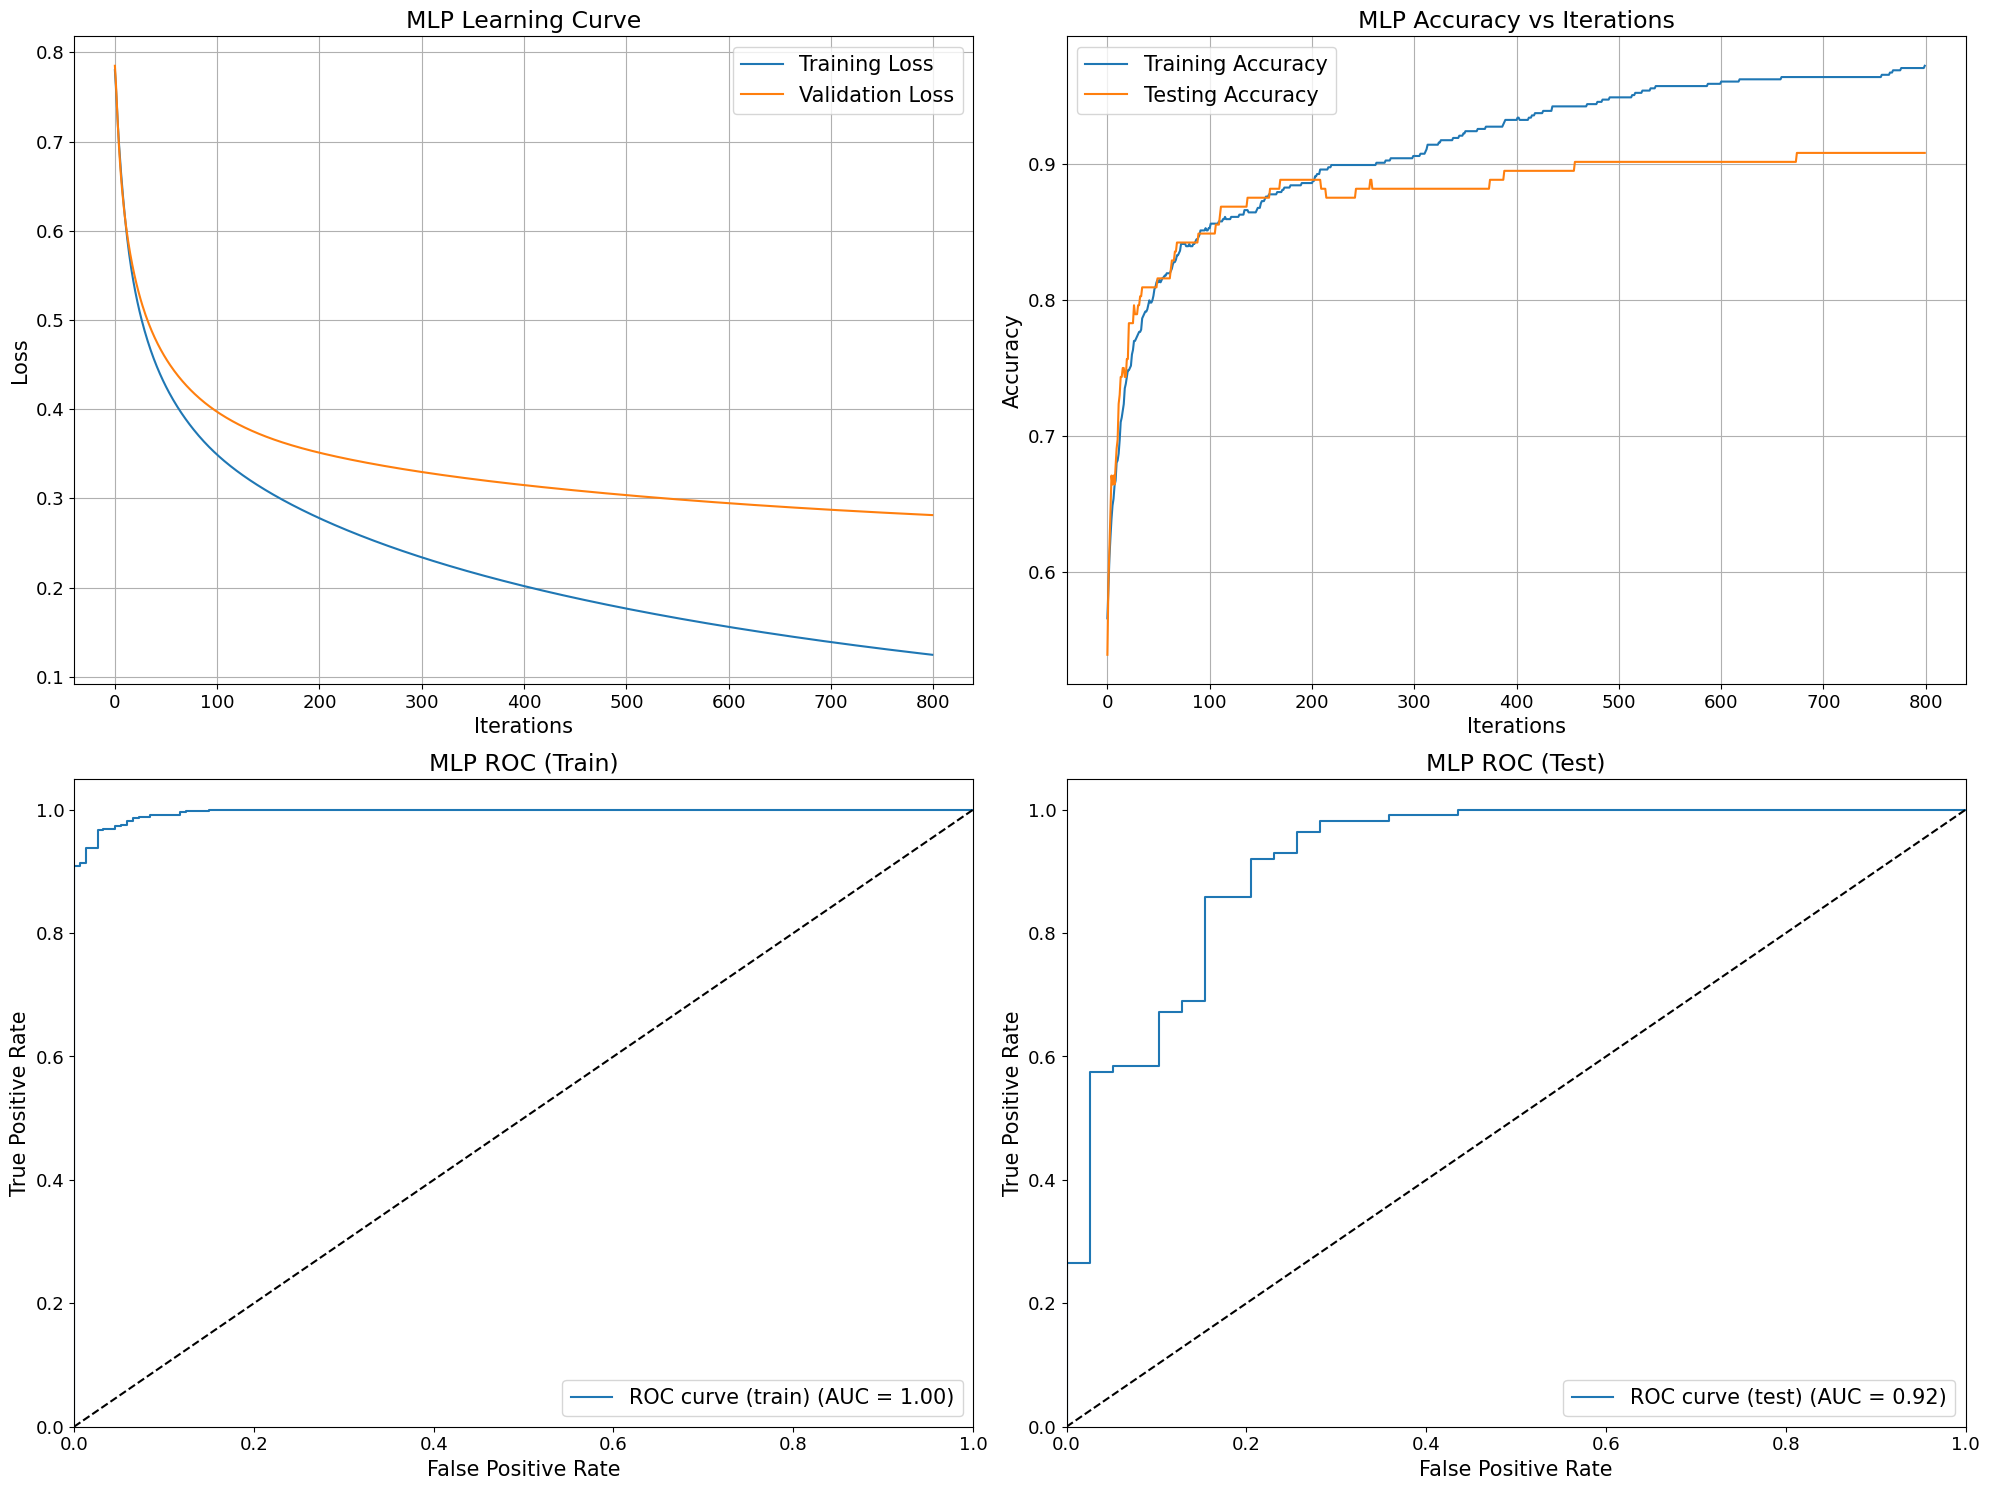

In [29]:
y_pred = mlp_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

print("Classification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plotting learning curve and ROC curve
plt.figure(figsize=(20, 15))

plt.subplot(2, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('MLP Learning Curve', fontsize=17)
plt.xlabel('Iterations', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=15)
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Testing Accuracy')
plt.title('MLP Accuracy vs Iterations', fontsize=17)
plt.xlabel('Iterations', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=15)
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(fpr_train, tpr_train, label='ROC curve (train) (AUC = {:.2f})'.format(roc_auc_train[-1]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('MLP ROC (Train)', fontsize=17)
plt.legend(loc="lower right", fontsize=15)

plt.subplot(2, 2, 4)
plt.plot(fpr_test, tpr_test, label='ROC curve (test) (AUC = {:.2f})'.format(roc_auc_test[-1]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('MLP ROC (Test)', fontsize=17)
plt.legend(loc="lower right", fontsize=15)

plt.tight_layout()
plt.show()

0.30 correlation cutoff:
- Accuracy: 0.8355263157894737
- Precision: 0.8279393039049235
- Recall: 0.8355263157894737
- F1-score: 0.825841644542113

0.38 correlation cutoff:
- Accuracy: 0.8355263157894737
- Precision: 0.8438891070960984
- Recall: 0.8355263157894737
- F1-score: 0.812220328148306

Applying 50 Comp PCA:
- Accuracy: 0.8947368421052632
- Precision: 0.8947368421052632
- Recall: 0.8947368421052632
- F1-score: 0.8947368421052632

Applying 25 Comp PCA:
- Accuracy: 0.9013157894736842
- Precision: 0.8992660177362649
- Recall: 0.9013157894736842
- F1-score: 0.8990042041592149

Applying 15 Comp PCA:
- Accuracy: 0.881578947368421
- Precision: 0.8798781619147752
- Recall: 0.881578947368421
- F1-score: 0.8805401662049861

In [13]:
print(conf_matrix)

[[ 29  10]
 [  4 109]]


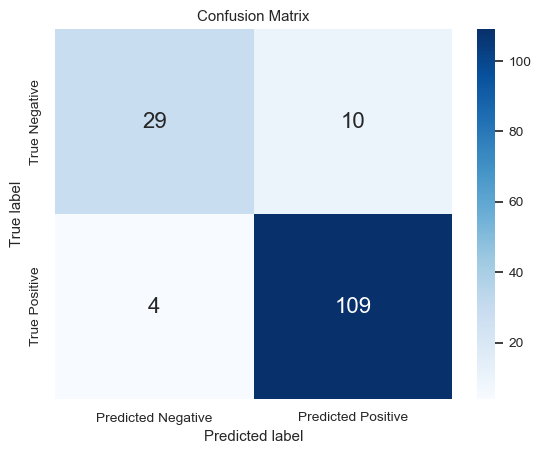

In [14]:
conf_matrix = [conf_matrix[0], conf_matrix[1]]
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']

# Plot confusion matrix
sns.set(font_scale=0.9)  # for label size
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['True Negative', 'True Positive'])

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

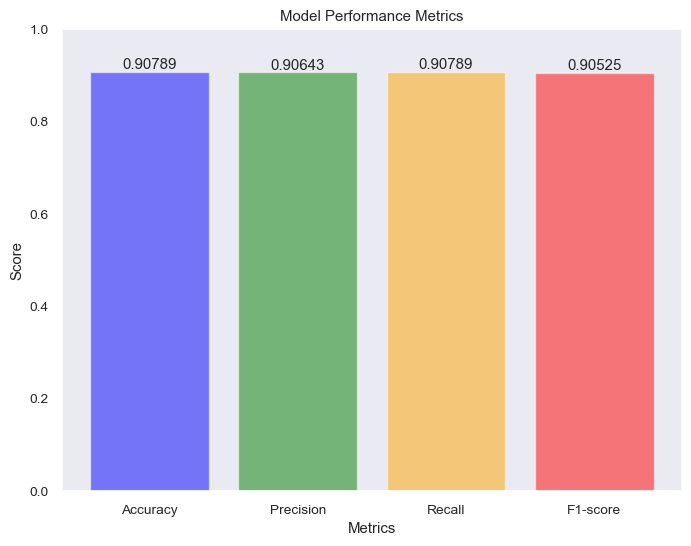

In [15]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
scores = [accuracy, precision, recall, f1]

# Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(metrics, scores, color=['blue', 'green', 'orange', 'red'], alpha=0.5)  # Set bar transparency
plt.title('Model Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.grid(False) 

# Add text annotations
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(score, 5), ha='center', va='bottom')

plt.show()

# Overall Performance

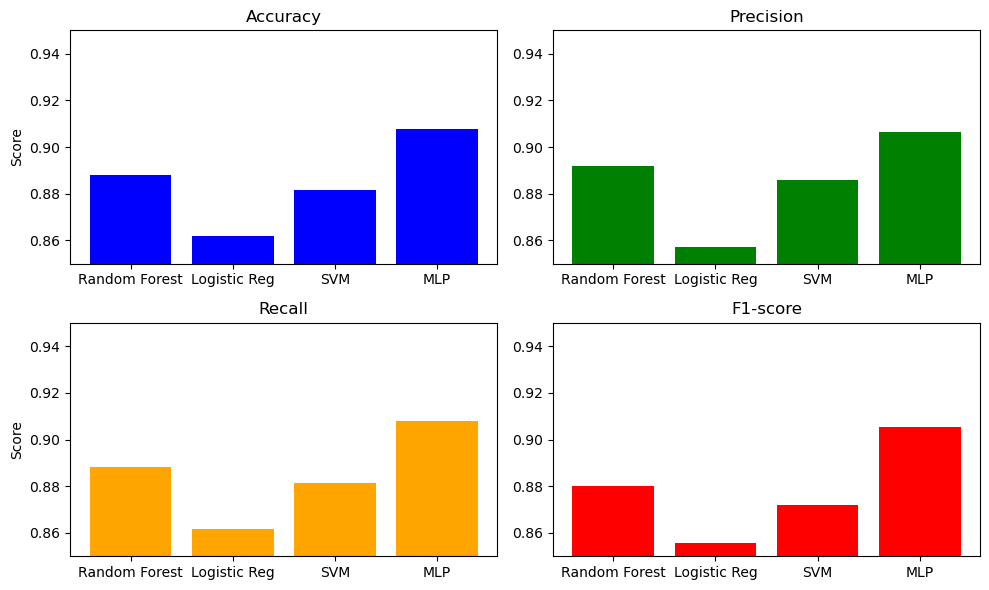

In [26]:
accuracy_scores = [0.8881578947368421, 0.8618421052631579, 0.881578947368421, 0.9078947368421053]
precision_scores = [0.8917606516290726, 0.8572799827437445, 0.885814338997099, 0.9064271641671022]
recall_scores = [0.8881578947368421, 0.8618421052631579, 0.881578947368421, 0.9078947368421053]
f1_scores = [0.8800154151068046, 0.855477384488047, 0.872080592105263, 0.905248033877798]

models = ['Random Forest', 'Logistic Reg', 'SVM', 'MLP']

# Plotting
plt.figure(figsize=(10, 6))

# Accuracy plot
plt.subplot(2, 2, 1)
plt.bar(models, accuracy_scores, color='blue')
plt.title('Accuracy')
plt.ylim([0.85, 0.95])
plt.ylabel('Score')

# Precision plot
plt.subplot(2, 2, 2)
plt.bar(models, precision_scores, color='green')
plt.title('Precision')
plt.ylim([0.85, 0.95])

# Recall plot
plt.subplot(2, 2, 3)
plt.bar(models, recall_scores, color='orange')
plt.title('Recall')
plt.ylim([0.85, 0.95])
plt.ylabel('Score')

# F1-score plot
plt.subplot(2, 2, 4)
plt.bar(models, f1_scores, color='red')
plt.title('F1-score')
plt.ylim([0.85, 0.95])

plt.tight_layout()
plt.show()

## Permutation Importance

PC1: 0.13026315789473691
PC6: 0.11743421052631582
PC3: 0.06381578947368427
PC2: 0.06315789473684216
PC7: 0.06184210526315794
PC15: 0.052302631578947434
PC4: 0.04440789473684217
PC5: 0.038157894736842154
PC8: 0.029934210526315848
PC25: 0.02565789473684214
PC9: 0.025000000000000043
PC21: 0.021052631578947417
PC23: 0.016776315789473722
PC11: 0.016776315789473716
PC16: 0.01578947368421057
PC12: 0.013486842105263191
PC13: 0.013486842105263191
PC10: 0.011513157894736881
PC19: 0.01085526315789478
PC22: 0.008552631578947412
PC14: 0.00822368421052636
PC20: 0.00822368421052635
PC18: 0.006250000000000045
PC17: 0.004276315789473734
PC24: -0.00263157894736839


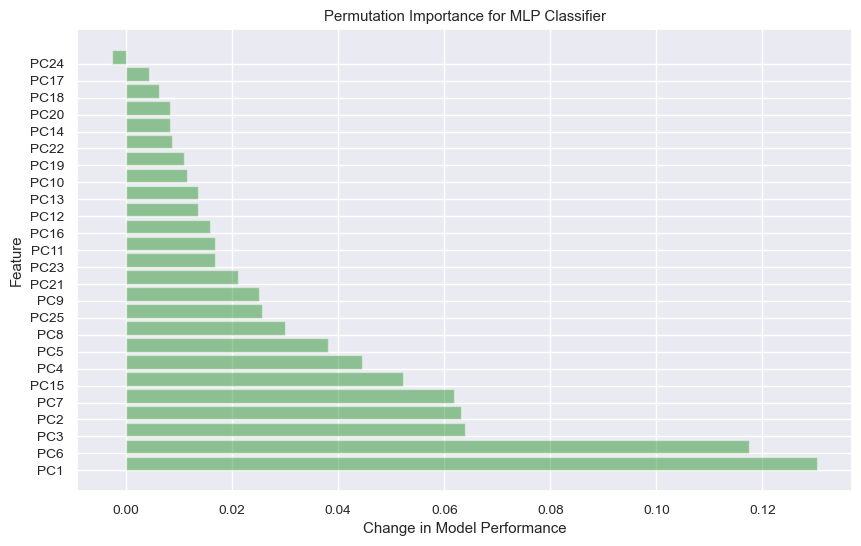

In [17]:
perm_importance = permutation_importance(mlp_classifier, X_test, y_test, n_repeats=20, random_state=28)

feature_importance = perm_importance.importances_mean
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_features = np.array(X.columns)[sorted_indices]

for feature, importance in zip(sorted_features, feature_importance[sorted_indices]):
    print(f"{feature}: {importance}")

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_features)), feature_importance[sorted_indices], align='edge', color="green", alpha=0.4)
plt.yticks(range(len(sorted_features)), sorted_features)
plt.xlabel('Change in Model Performance')
plt.ylabel('Feature')
plt.title('Permutation Importance for MLP Classifier')
plt.show()

In [31]:
# Random Forest Model
perm_importance_rf = permutation_importance(rf_classifier, X_test, y_test, n_repeats=20, random_state=28)
feature_importance_rf = perm_importance_rf.importances_mean
sorted_indices_rf = np.argsort(feature_importance_rf)[::-1]
sorted_features_rf = np.array(X.columns)[sorted_indices_rf]

# Logistic Regression Model
perm_importance_lr = permutation_importance(logreg_classifier, X_test, y_test, n_repeats=20, random_state=28)
feature_importance_lr = perm_importance_lr.importances_mean
sorted_indices_lr = np.argsort(feature_importance_lr)[::-1]
sorted_features_lr = np.array(X.columns)[sorted_indices_lr]

# SVM Model
perm_importance_svm = permutation_importance(svm_classifier, X_test, y_test, n_repeats=20, random_state=28)
feature_importance_svm = perm_importance_svm.importances_mean
sorted_indices_svm = np.argsort(feature_importance_svm)[::-1]
sorted_features_svm = np.array(X.columns)[sorted_indices_svm]

# MLP Model
perm_importance_mlp = permutation_importance(mlp_classifier, X_test, y_test, n_repeats=20, random_state=28)
feature_importance_mlp = perm_importance_mlp.importances_mean
sorted_indices_mlp = np.argsort(feature_importance_mlp)[::-1]
sorted_features_mlp = np.array(X.columns)[sorted_indices_mlp]

Top 5 features for Random Forest Classifier:
PC1: 0.09868421052631583
PC6: 0.03618421052631583
PC7: 0.01973684210526321
PC15: 0.0197368421052632
PC5: 0.01447368421052635


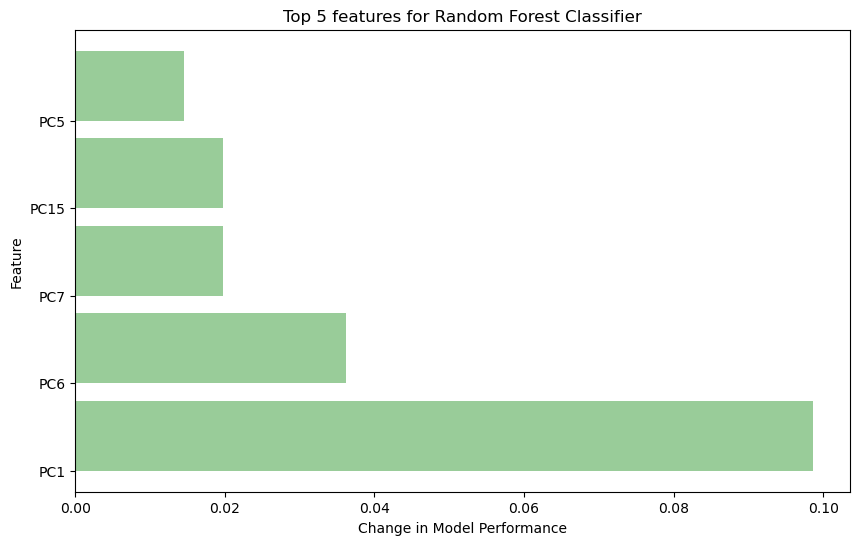

Top 5 features for Logistic Regression Classifier:
PC1: 0.1526315789473684
PC6: 0.08749999999999994
PC7: 0.0407894736842105
PC5: 0.01842105263157893
PC15: 0.01578947368421051


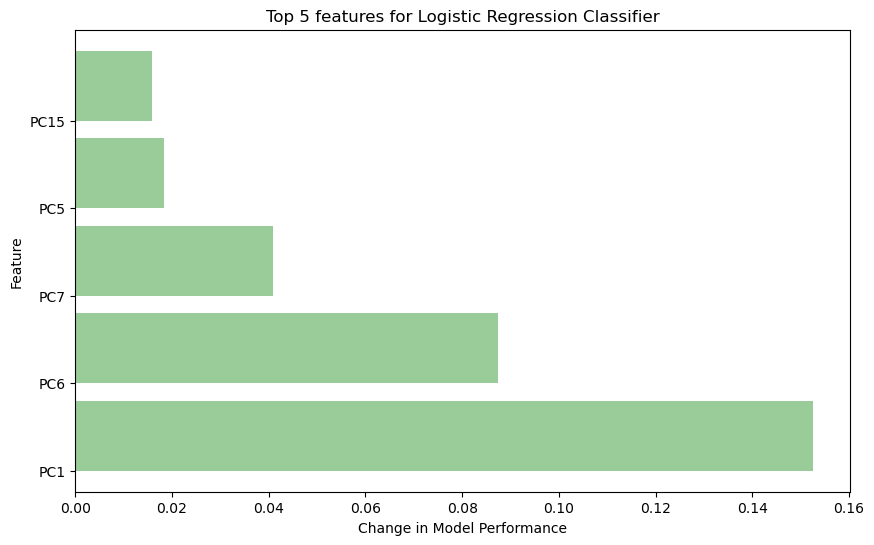

Top 5 features for SVM Classifier:
PC1: 0.1269736842105263
PC6: 0.03618421052631575
PC15: 0.024999999999999967
PC7: 0.015789473684210485
PC8: 0.015789473684210485


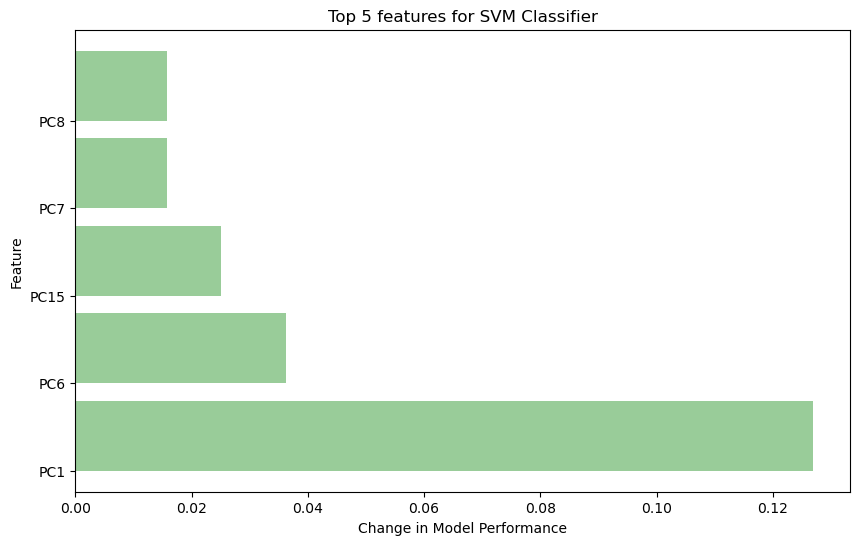

Top 5 features for MLP Classifier:
PC1: 0.13815789473684212
PC6: 0.12368421052631581
PC3: 0.059210526315789526
PC7: 0.05789473684210532
PC15: 0.055921052631578996


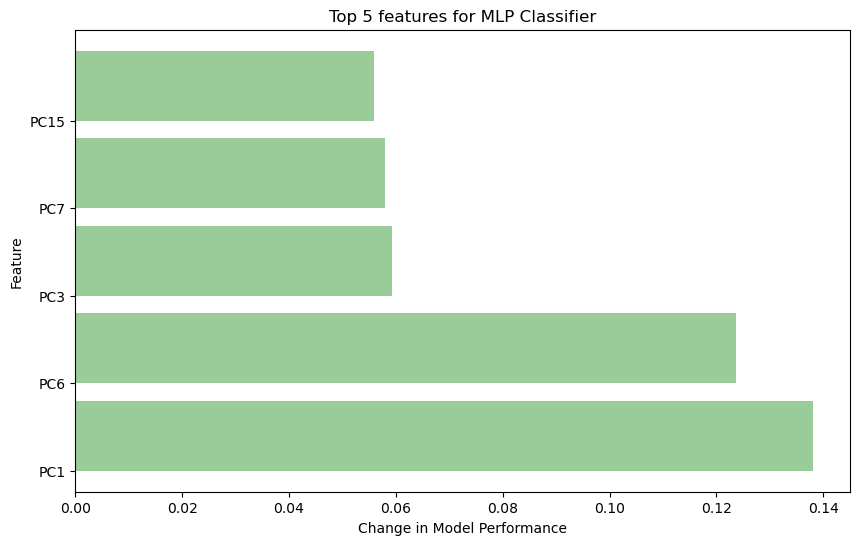

In [35]:
models = {
    "Random Forest": rf_classifier,
    "Logistic Regression": logreg_classifier,
    "SVM": svm_classifier,
    "MLP": mlp_classifier
}

# Iterate over each model
for model_name, model in models.items():
    # Calculate permutation importance
    perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=28)
    feature_importance = perm_importance.importances_mean
    sorted_indices = np.argsort(feature_importance)[::-1]
    sorted_features = np.array(X.columns)[sorted_indices]
    
    # Print top 5 features for the model
    print(f"Top 5 features for {model_name} Classifier:")
    for feature, importance in zip(sorted_features[:5], feature_importance[sorted_indices][:5]):
        print(f"{feature}: {importance}")
    
    # Plot permutation importance for the model
    plt.figure(figsize=(10, 6))
    plt.barh(range(5), feature_importance[sorted_indices][:5], align='edge', color="green", alpha=0.4)
    plt.yticks(range(5), sorted_features[:5])
    plt.xlabel('Change in Model Performance')
    plt.ylabel('Feature')
    plt.title(f'Top 5 features for {model_name} Classifier')
    plt.show()

In [40]:
loadings = pca.components_.T  # Transpose the components to align with original variables

# Create a DataFrame to store the loadings
loadings_df = pd.DataFrame(loadings, columns=[f'PC{i}' for i in range(1, pca.n_components_ + 1)], index=og_df.columns[:-1])  # Exclude the 'class' column

# Display the loadings for each principal component
print("Loadings for each principal component:")
print(loadings_df)

# Interpret the loadings for each principal component
for i in range(1, pca.n_components_ + 1):
    print(f"\nPrincipal Component {i}:")
    pc_loadings = loadings_df[f'PC{i}'].sort_values(ascending=False)
    print(pc_loadings)

Loadings for each principal component:
                                PC1       PC2       PC3       PC4       PC5  \
id                         0.007343  0.001167  0.006515 -0.014921  0.023002   
gender                    -0.045027  0.047010 -0.006293  0.024210 -0.010259   
PPE                        0.017370  0.010454 -0.057664  0.012229  0.005479   
DFA                       -0.049219  0.002469  0.001581 -0.063115  0.071696   
RPDE                      -0.054996  0.004581  0.049507  0.018911  0.005000   
...                             ...       ...       ...       ...       ...   
tqwt_kurtosisValue_dec_32  0.004751  0.006688 -0.016981  0.003938 -0.057343   
tqwt_kurtosisValue_dec_33  0.001353  0.005676 -0.018807  0.001422 -0.056976   
tqwt_kurtosisValue_dec_34 -0.013247 -0.008585 -0.021764  0.013271 -0.035812   
tqwt_kurtosisValue_dec_35 -0.019424 -0.017181 -0.022718  0.017911 -0.023369   
tqwt_kurtosisValue_dec_36 -0.029021 -0.035710 -0.029009  0.024335 -0.014069   

            

## Random Forest Modeling Running

### Correlation Map

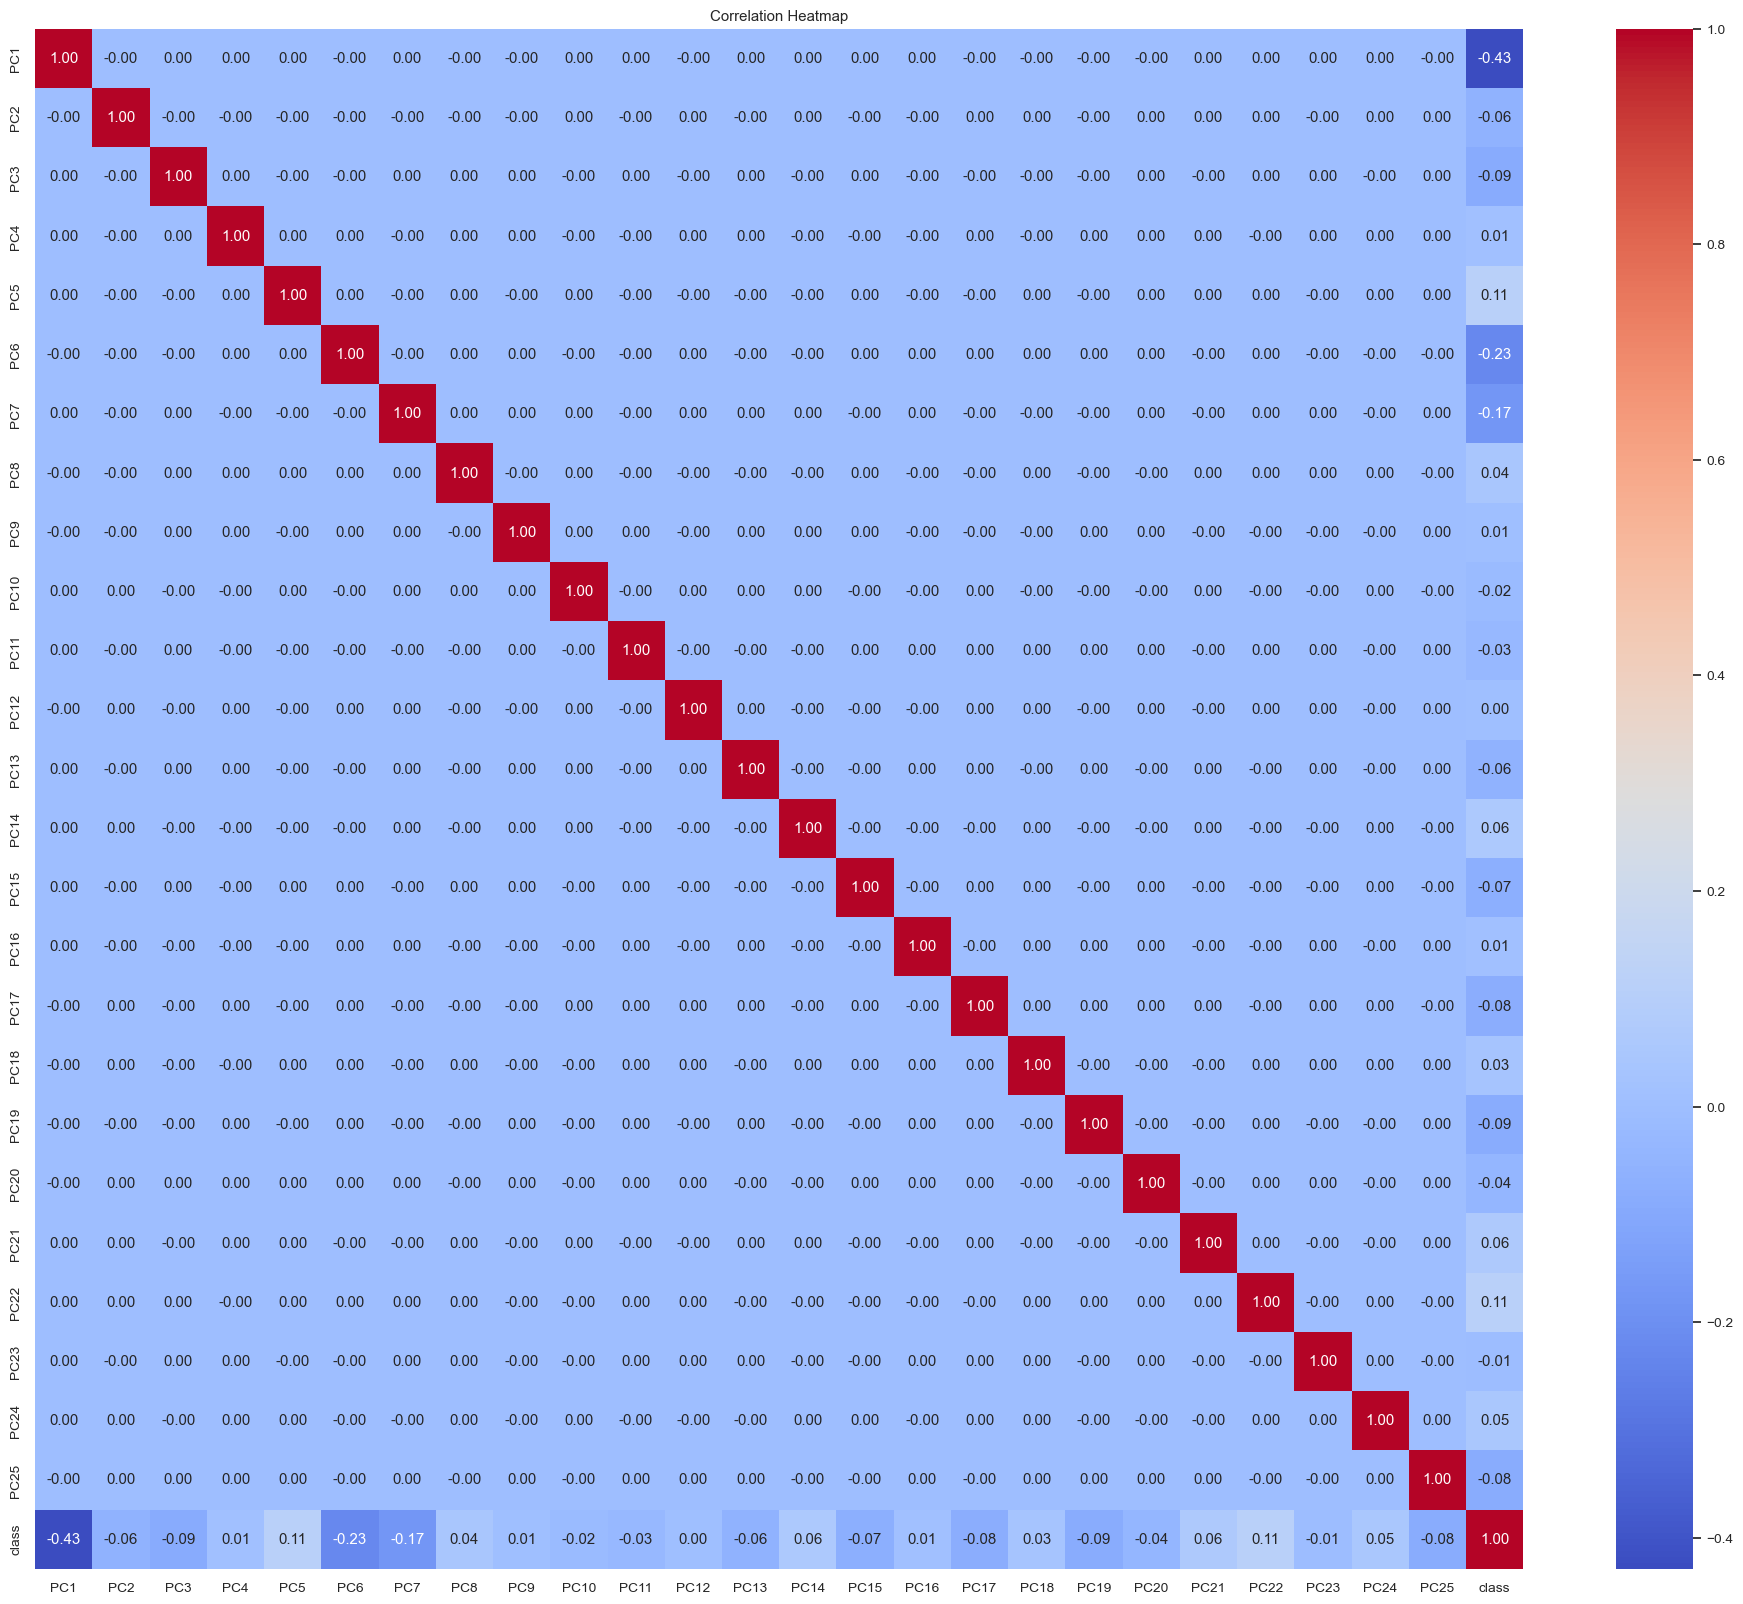

In [25]:
correlation_matrix = reduced_df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(24, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

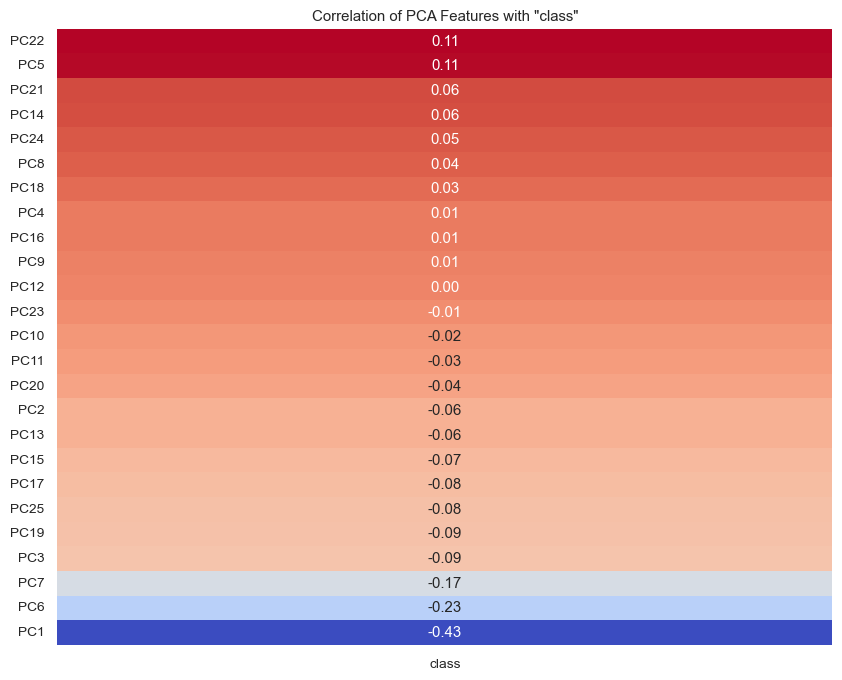

In [24]:
correlation_matrix = reduced_df.corr()

# Filter the correlations related to 'class'
class_correlations = correlation_matrix['class'].drop('class')

# Sort correlations from most correlated to least
class_correlations_sorted = class_correlations.sort_values(ascending=False)

# Plot the correlations
plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(class_correlations_sorted), annot=True, cmap='coolwarm', fmt=".2f", cbar=False)
plt.title('Correlation of PCA Features with "class"')
plt.show()